## Importing all the necessary libraries

In [26]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torchvision import models
import torch.nn as nn

import os
import random

## Loading fine-tuned model

In [18]:
# Selecting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Loading saved model
model = models.efficientnet_b0()
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

cuda


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Implementation of Grad-CAM

In [ ]:
def grad_cam(model, img_tensor, target_class, orig_size=(224, 224)):
    model.eval()
    
    # Moving model and input tensor to the same device
    device = next(model.parameters()).device
    img_tensor = img_tensor.to(device).unsqueeze(0)
    img_tensor.requires_grad_(True)

    # Getting the last convolutional layer
    last_conv_layer = model.features[8]
    
    # Storing gradients and activations
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    # Registering hooks
    hook_b = last_conv_layer.register_backward_hook(backward_hook)
    hook_f = last_conv_layer.register_forward_hook(forward_hook)

    # Forward pass
    output = model(img_tensor)
    
    # Zeroing gradients and backward passing for the target class
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    output.backward(gradient=one_hot)

    # Computing Grad-CAM
    weights = torch.mean(gradients[0], dim=[2, 3], keepdim=True)  # Using global average pooling
    cam = torch.sum(weights * activations[0], dim=1, keepdim=True)
    cam = torch.relu(cam)
    
    # Resizing and normalizing
    cam = torch.nn.functional.interpolate(
        cam, size=orig_size, mode="bilinear", align_corners=False
    )
    cam = cam.squeeze().cpu().numpy()  # Moving to CPU for visualization
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalizing to [0, 1]

    # Removing hooks
    hook_b.remove()
    hook_f.remove()

    return cam

## Testing

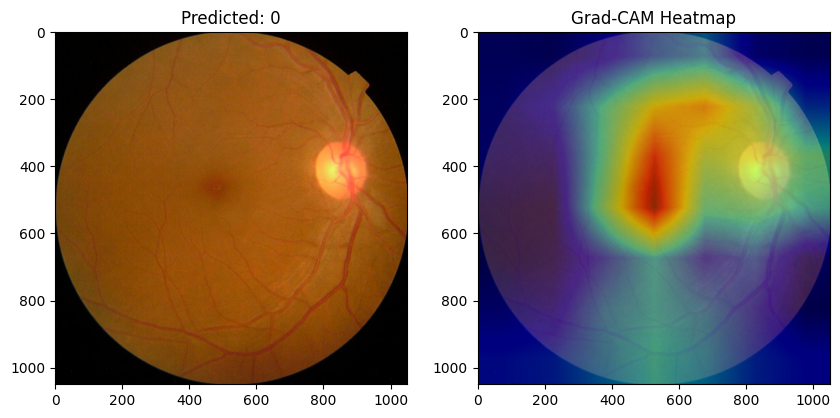

In [ ]:
# Loading a test image
test_img_path = "data/aptos2019/train_images/0a4e1a29ffff.png"
img = Image.open(test_img_path)
img_size = img.size[::-1]

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = transform(img).to(device).unsqueeze(0)

# Predicting class
with torch.no_grad():
    output = model(img_tensor)
    pred_class = torch.argmax(output).item()

# Generating Grad-CAM
heatmap = grad_cam(model, img_tensor.squeeze(0), pred_class, img_size)

# Visualizing
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Predicted: {pred_class}")

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title("Grad-CAM Heatmap")
plt.show()

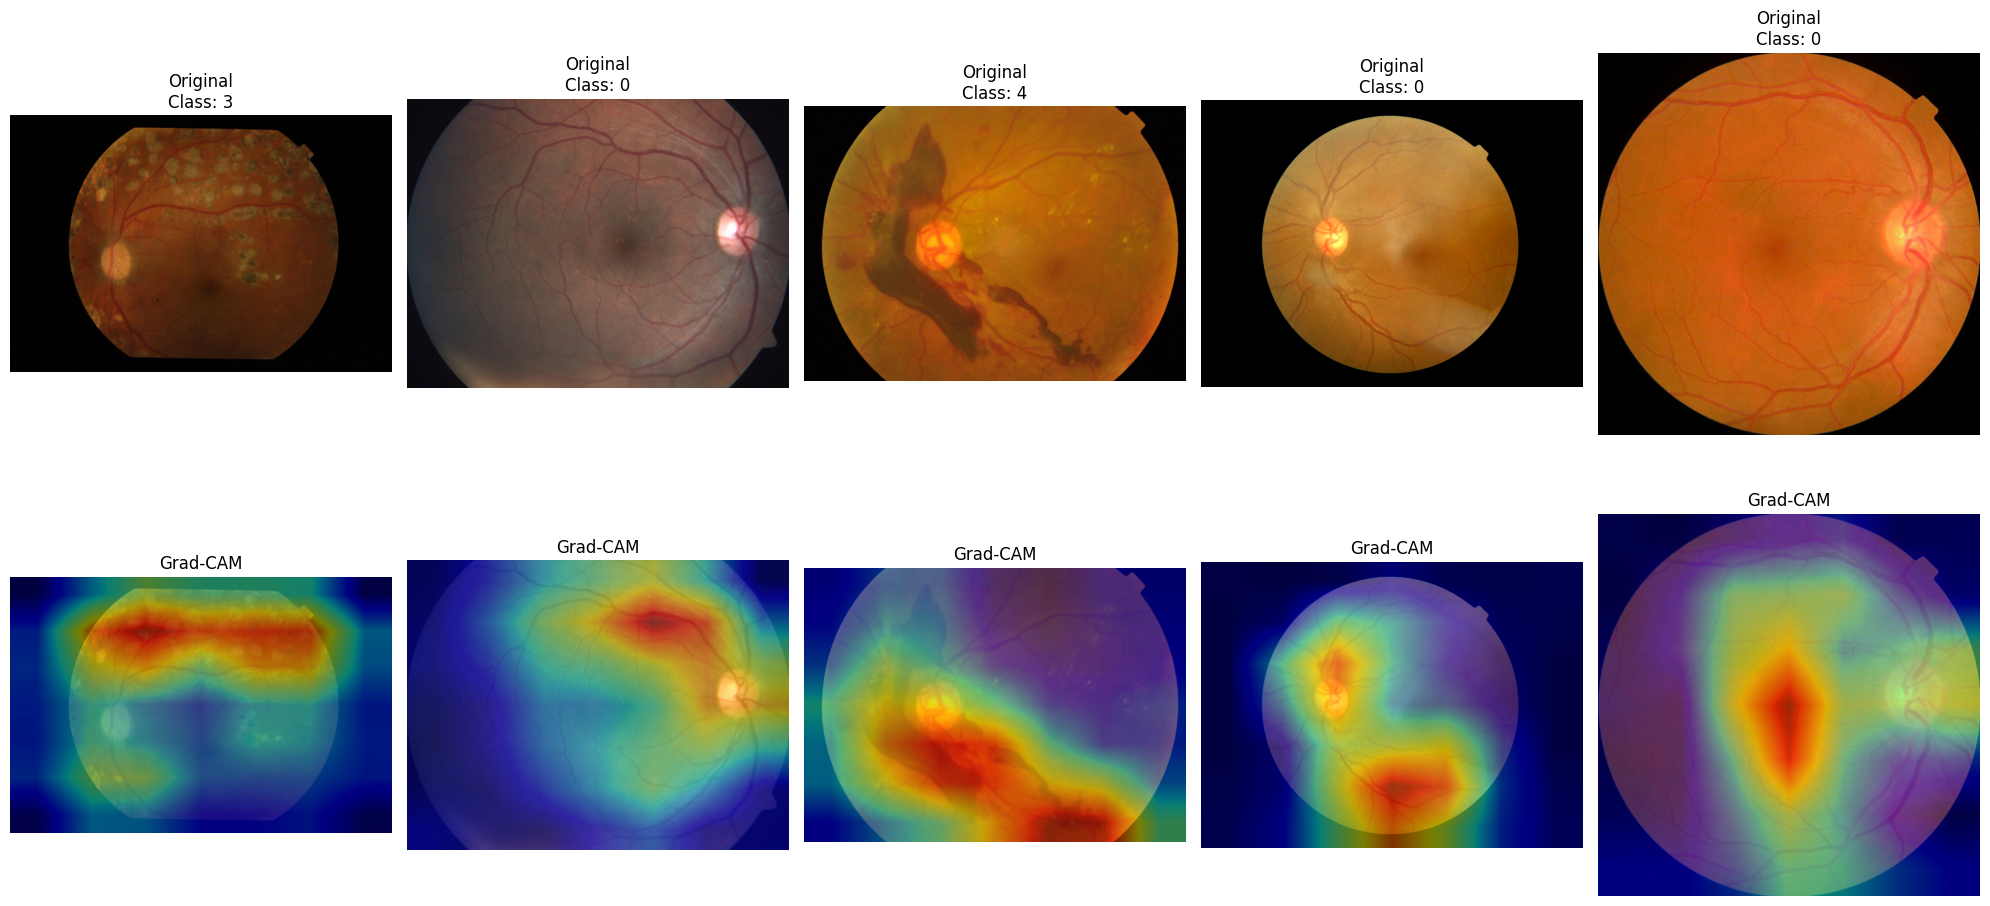

In [ ]:
image_dir = "data/aptos2019/train_images"
all_images = os.listdir(image_dir)
# Taking 5 random images
selected_images = random.sample(all_images, 5)

# Plotting predictions and Grad-CAM
plt.figure(figsize=(20, 10))

for i, img_name in enumerate(selected_images):
    # Loading image
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    img_size = img.size[::-1]
    
    # Preprocessing and predicting
    img_tensor = transform(img).to(device).unsqueeze(0)
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = torch.argmax(output).item()
    
    # Generating Grad-CAM
    heatmap = grad_cam(model, img_tensor.squeeze(0), pred_class, img_size)
    
    # Plotting original and overlayed
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Original\nClass: {pred_class}")
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(img)
    plt.imshow(heatmap, cmap="jet", alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis('off')

plt.tight_layout()
plt.show()